In [1]:
import pandas as pd
import numpy as np
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

## Spatial Manipulation
import geopandas as gpd
from shapely.geometry import Point

## Mapping
import folium
from folium import plugins

## Misc
import functools
from itertools import product
import contextily as ctx

pd.options.display.max_columns = None
#pd.options.display.max_rows = None

import matplotlib.colors as mcolors
import matplotlib.colors as colors

from mpl_toolkits.axes_grid1 import make_axes_locatable

from sklearn import preprocessing

In [2]:
df = pd.read_csv('pm_no_clean.csv', index_col = 0)

In [3]:
df['pop_difference'] = df['b_Workday Population (excludes tourists) (2014)'] - df['b_Population estimate 2014'] 

In [4]:
atlas = pd.read_csv('/Users/oliverpaul/Data_Science/EDF/to_merge/london_borough_atlas.csv')

In [5]:
atlas = atlas[['Borough', 'b_Population estimate 2014', 'b_Workday Population (excludes tourists) (2014)']]

In [6]:
atlas['pop_difference'] = atlas['b_Workday Population (excludes tourists) (2014)'] - atlas['b_Population estimate 2014']                                                                                                                                                                                 

In [7]:
atlas = atlas.rename(columns={"Borough": "borough"})

In [8]:
#load london borough shape file
fp = "/Users/oliverpaul/Data_Science/EDF/statistical-gis-boundaries-london/ESRI/London_Borough_Excluding_MHW.shp"
map_df = gpd.read_file(fp).to_crs({'init': 'epsg:4326'})
map_df = map_df.rename(columns={"NAME": "borough"})
map_df.sample(3)

borough   GSS_CODE  HECTARES  NONLD_AREA ONS_INNER SUB_2009  \
32        City of London  E09000001   314.942      24.546         T     None   
27             Islington  E09000019  1485.664       0.000         T     None   
19  Richmond upon Thames  E09000027  5876.111     135.443         F     None   

   SUB_2006                                           geometry  
32     None  POLYGON ((-0.11157 51.51075, -0.11159 51.51091...  
27     None  POLYGON ((-0.13839 51.55686, -0.13852 51.55701...  
19     None  POLYGON ((-0.32173 51.46541, -0.32172 51.46536...

In [9]:
borough_map = map_df.to_crs({'init': 'epsg:3857'})

In [10]:
#merging the two datasets together
borough_map = pd.merge(borough_map, atlas, how='left', on='borough')

In [11]:
scaler = preprocessing.StandardScaler()
borough_map['log_pop_difference'] = scaler.fit_transform(borough_map[["pop_difference"]])

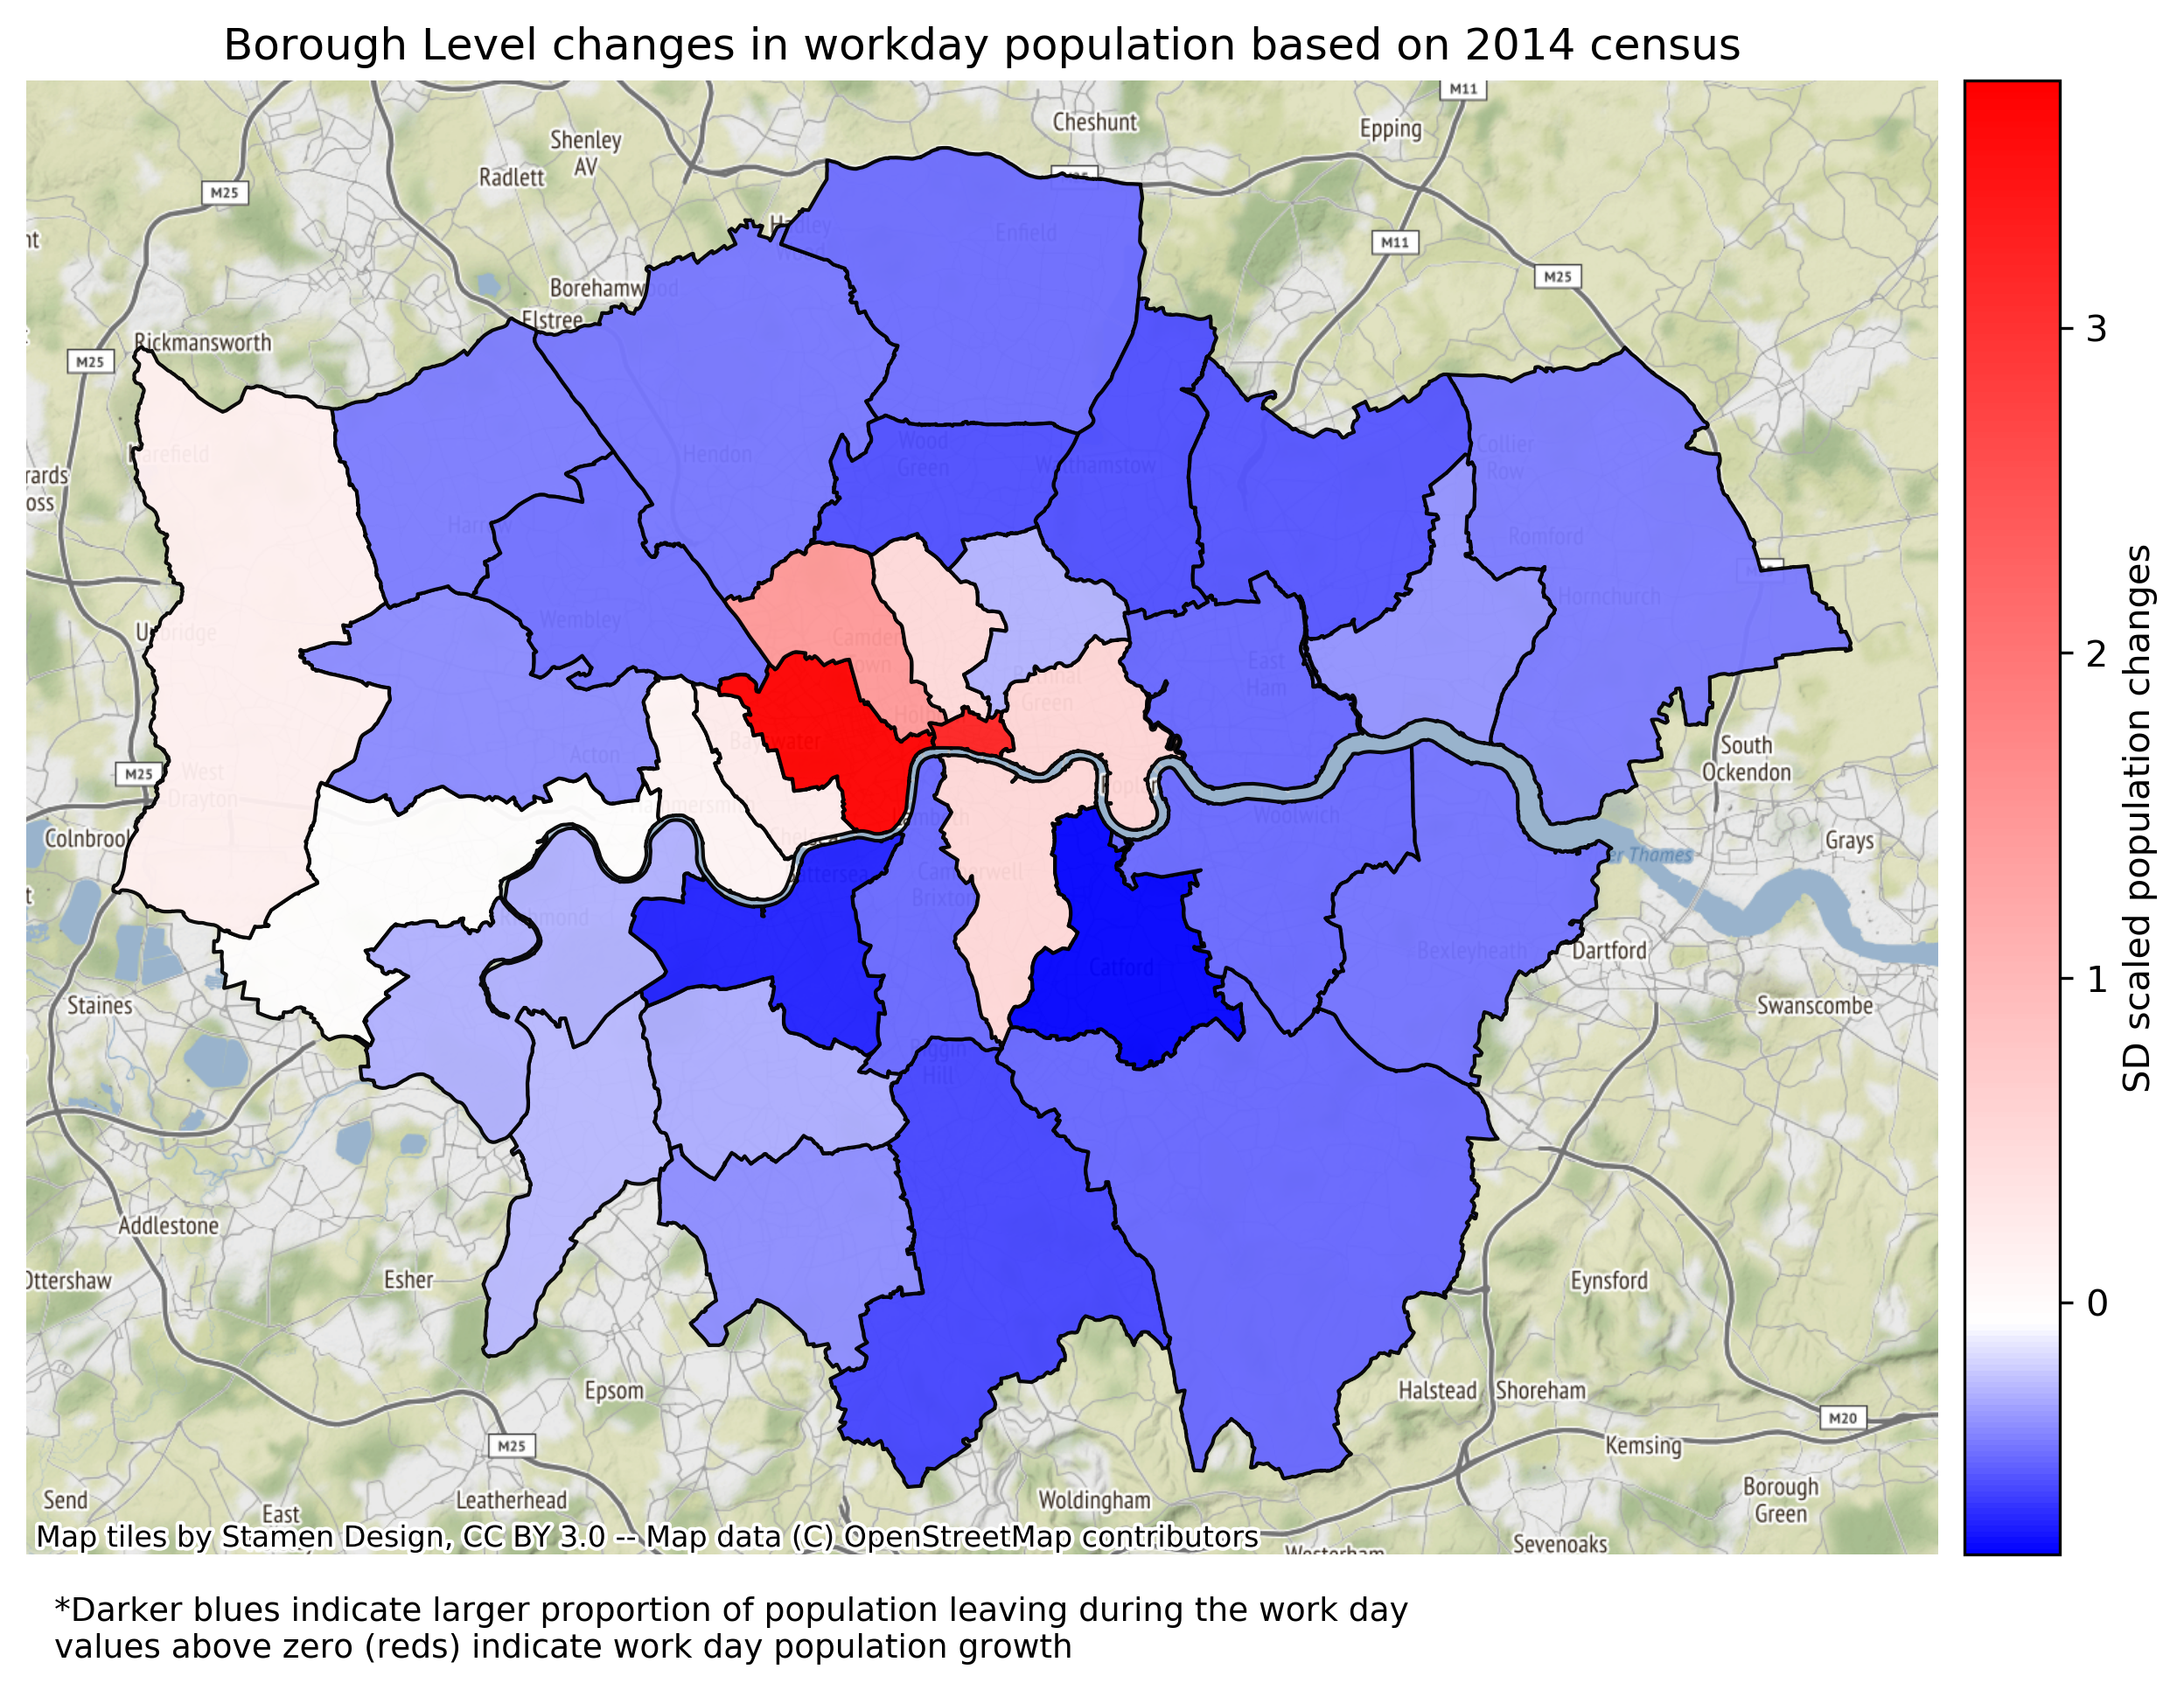

In [12]:
plt.rcParams['figure.dpi'] = 300

fig, ax = plt.subplots(1, 1, figsize=(10, 8))


offset = mcolors.DivergingNorm(vmin=-0.7747735,
                                   vcenter=-0.06, vmax=3.760611)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)

ax = borough_map.plot(figsize=(10, 8), 
                      column='log_pop_difference', 
                      cmap = 'bwr', 
                      edgecolor='k',
                      legend = False,
                      norm=offset,
                      linewidth=1,
                      alpha=0.95,
                      ax=ax) 


cbar = plt.cm.ScalarMappable(norm=offset, cmap='bwr')
ax_cbar = fig.colorbar(cbar, ax=ax, cax=cax)
ax_cbar.set_label('SD scaled population changes')

ax.set_title('Borough Level changes in workday population based on 2014 census', 
                 fontdict={'fontsize': '12', 'fontweight' : '2'})

ctx.add_basemap(ax=ax)

ax.annotate(s= '*Darker blues indicate larger proportion of population leaving during the work day\nvalues above zero (reds) indicate work day population growth', 
            xy=(-60000,6663000), annotation_clip=False, size=9)
ax.axis('off')
plt.show()

### Clearly employment and commercial activity in the centre of London is driving daytime migration. As we see from below pollution model, this matches pollution gradient. Could remote working, or employment opportunities outside the centre be a partial solution? What about stimulating economic growth in the outer boroughs of London?

<img src="pollution.png">

In [13]:
borough_map = borough_map.sort_values(['pop_difference']).reset_index(drop=True)

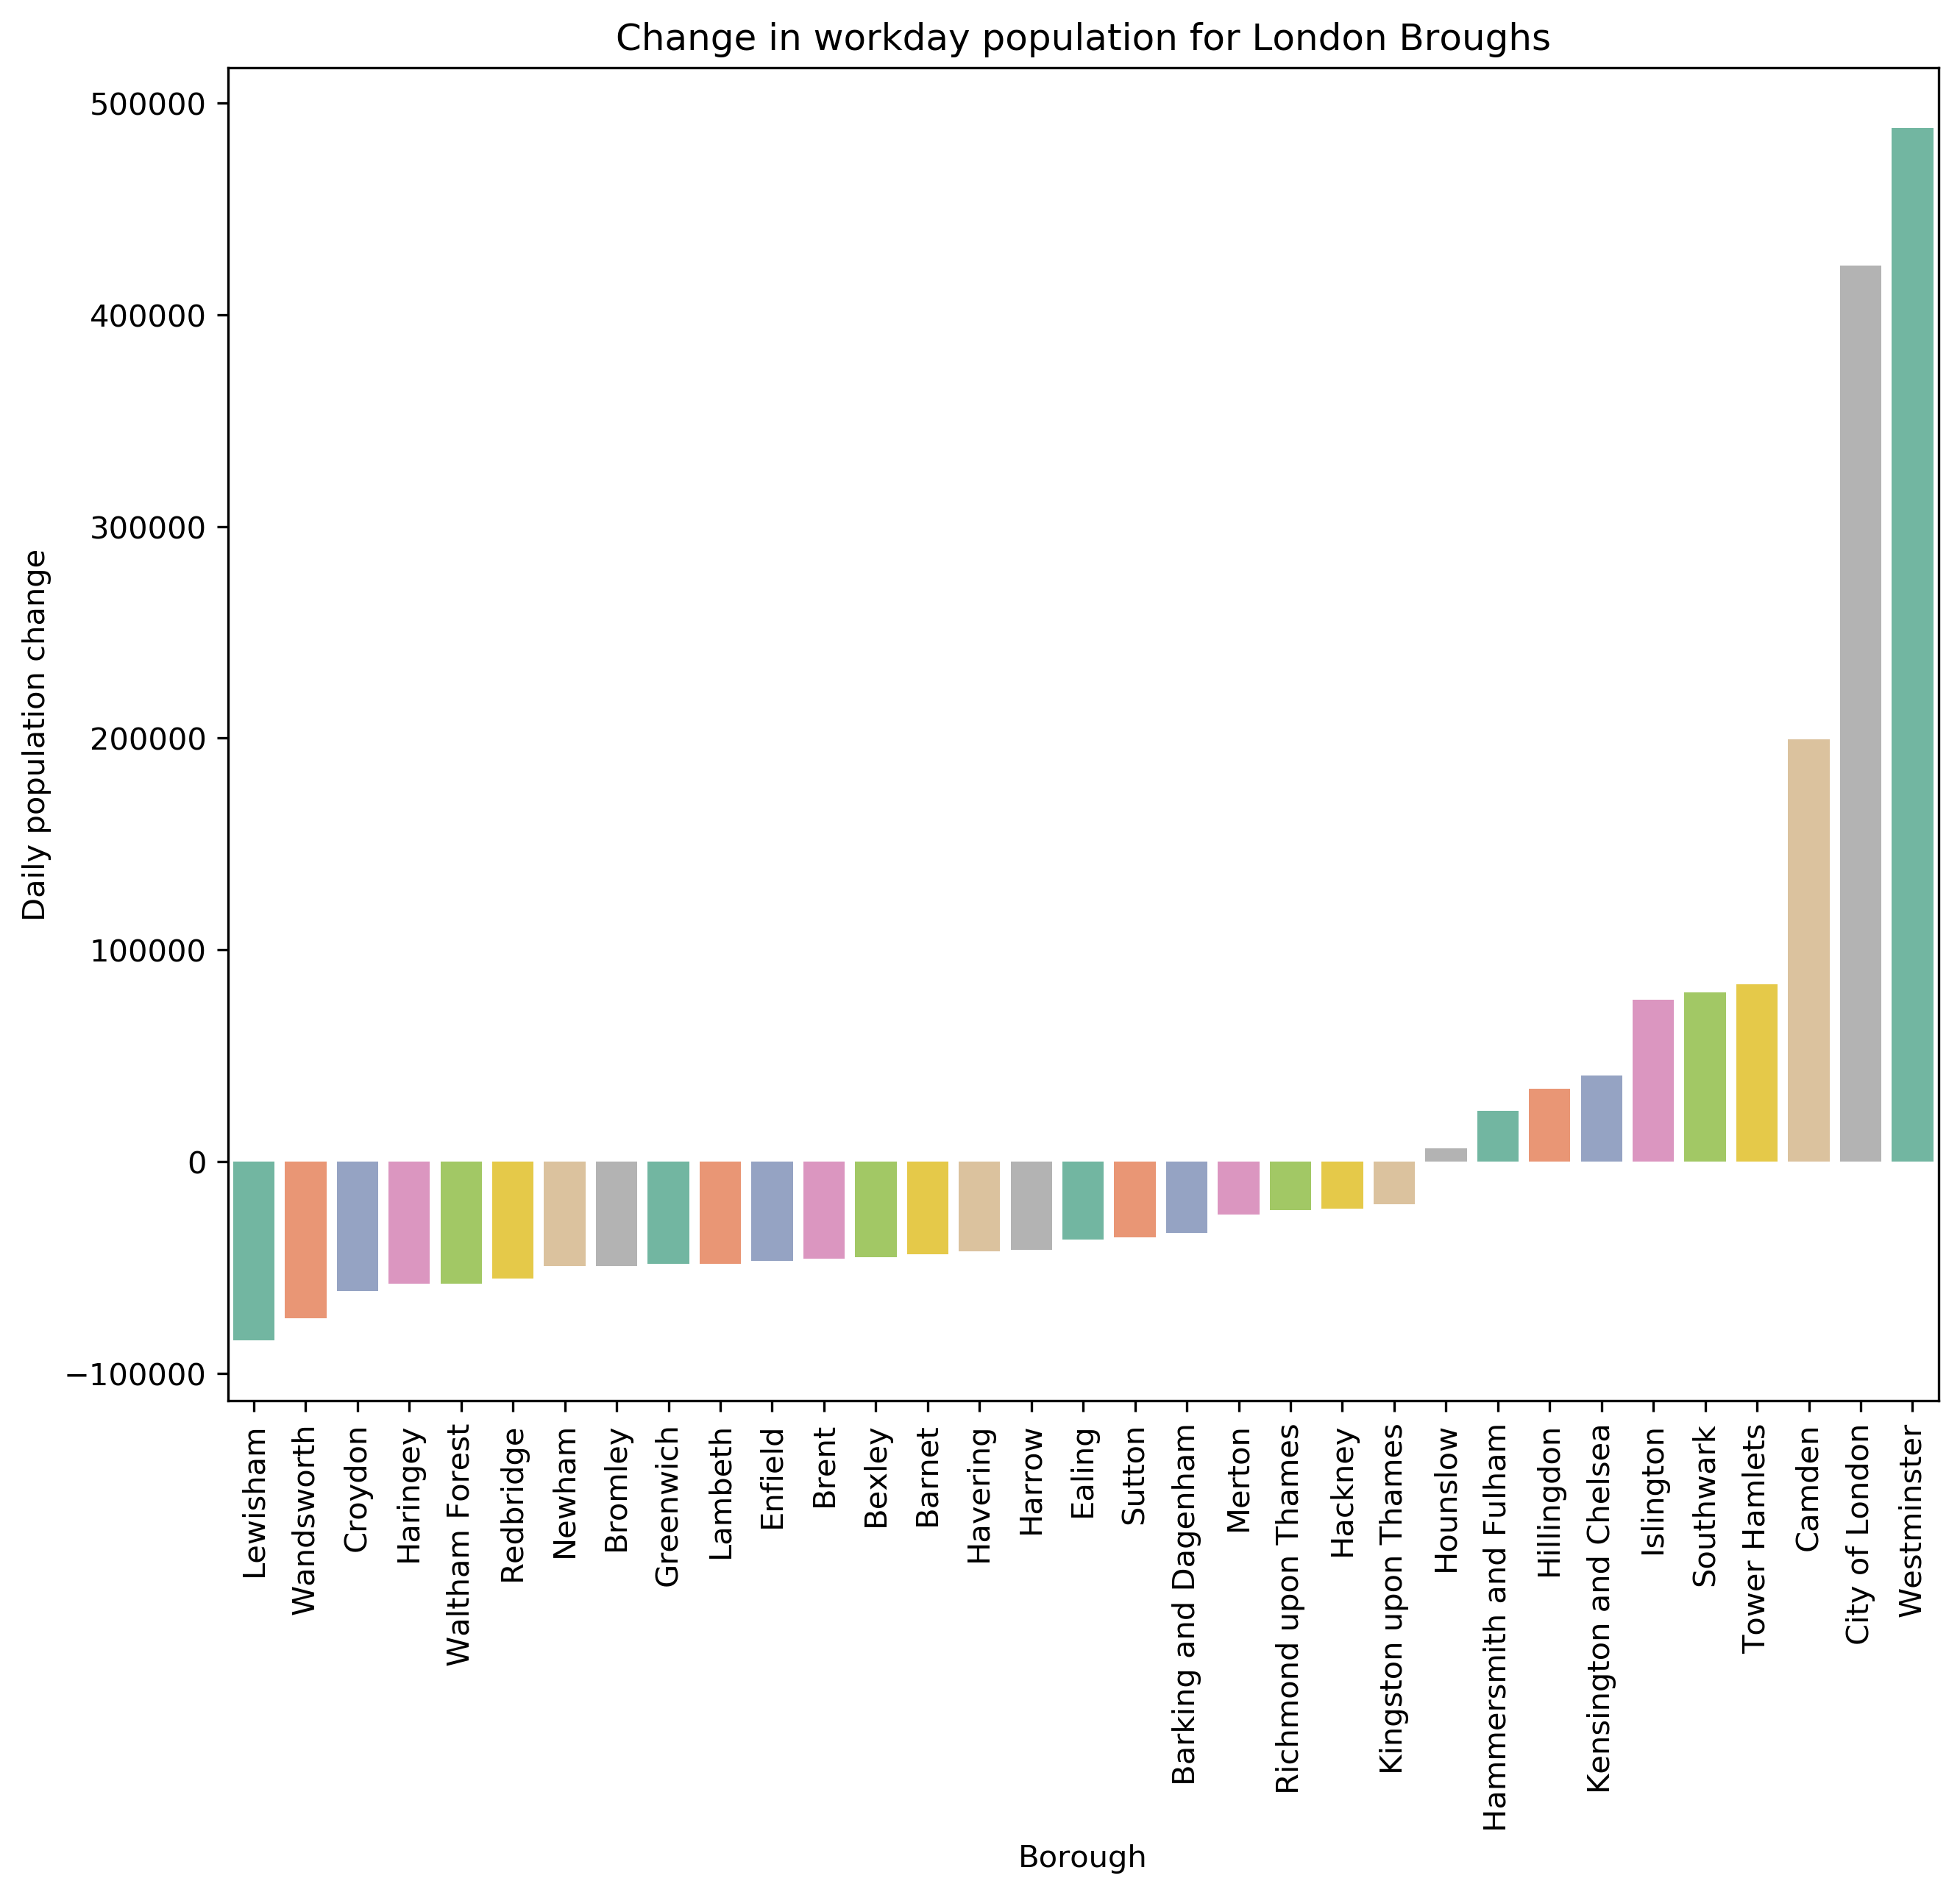

In [14]:
plt.rcParams['figure.dpi'] = 300

fig, ax = plt.subplots(1, 1, figsize=(10, 8))

ax = sns.barplot(x='borough', 
                 y='pop_difference', 
                 data=borough_map,
                palette = 'Set2')

ax.set_xlabel('Borough')
ax.set_ylabel('Daily population change')
ax.set_title('Change in workday population for London Broughs', fontdict={'fontsize': '12', 'fontweight' : '2'})

plt.xticks(rotation=90)
plt.show()

### Cycling map

In [15]:
cycle= pd.read_csv('/Users/oliverpaul/Data_Science/EDF/to_merge/london_borough_atlas.csv')
cycle=cycle[['Borough', 'b_percentage adults cycle once a month 2014/15']]
cycle = cycle.rename(columns={"Borough": "borough"})

In [16]:
borough_map = pd.merge(borough_map, cycle, how='left', on='borough')

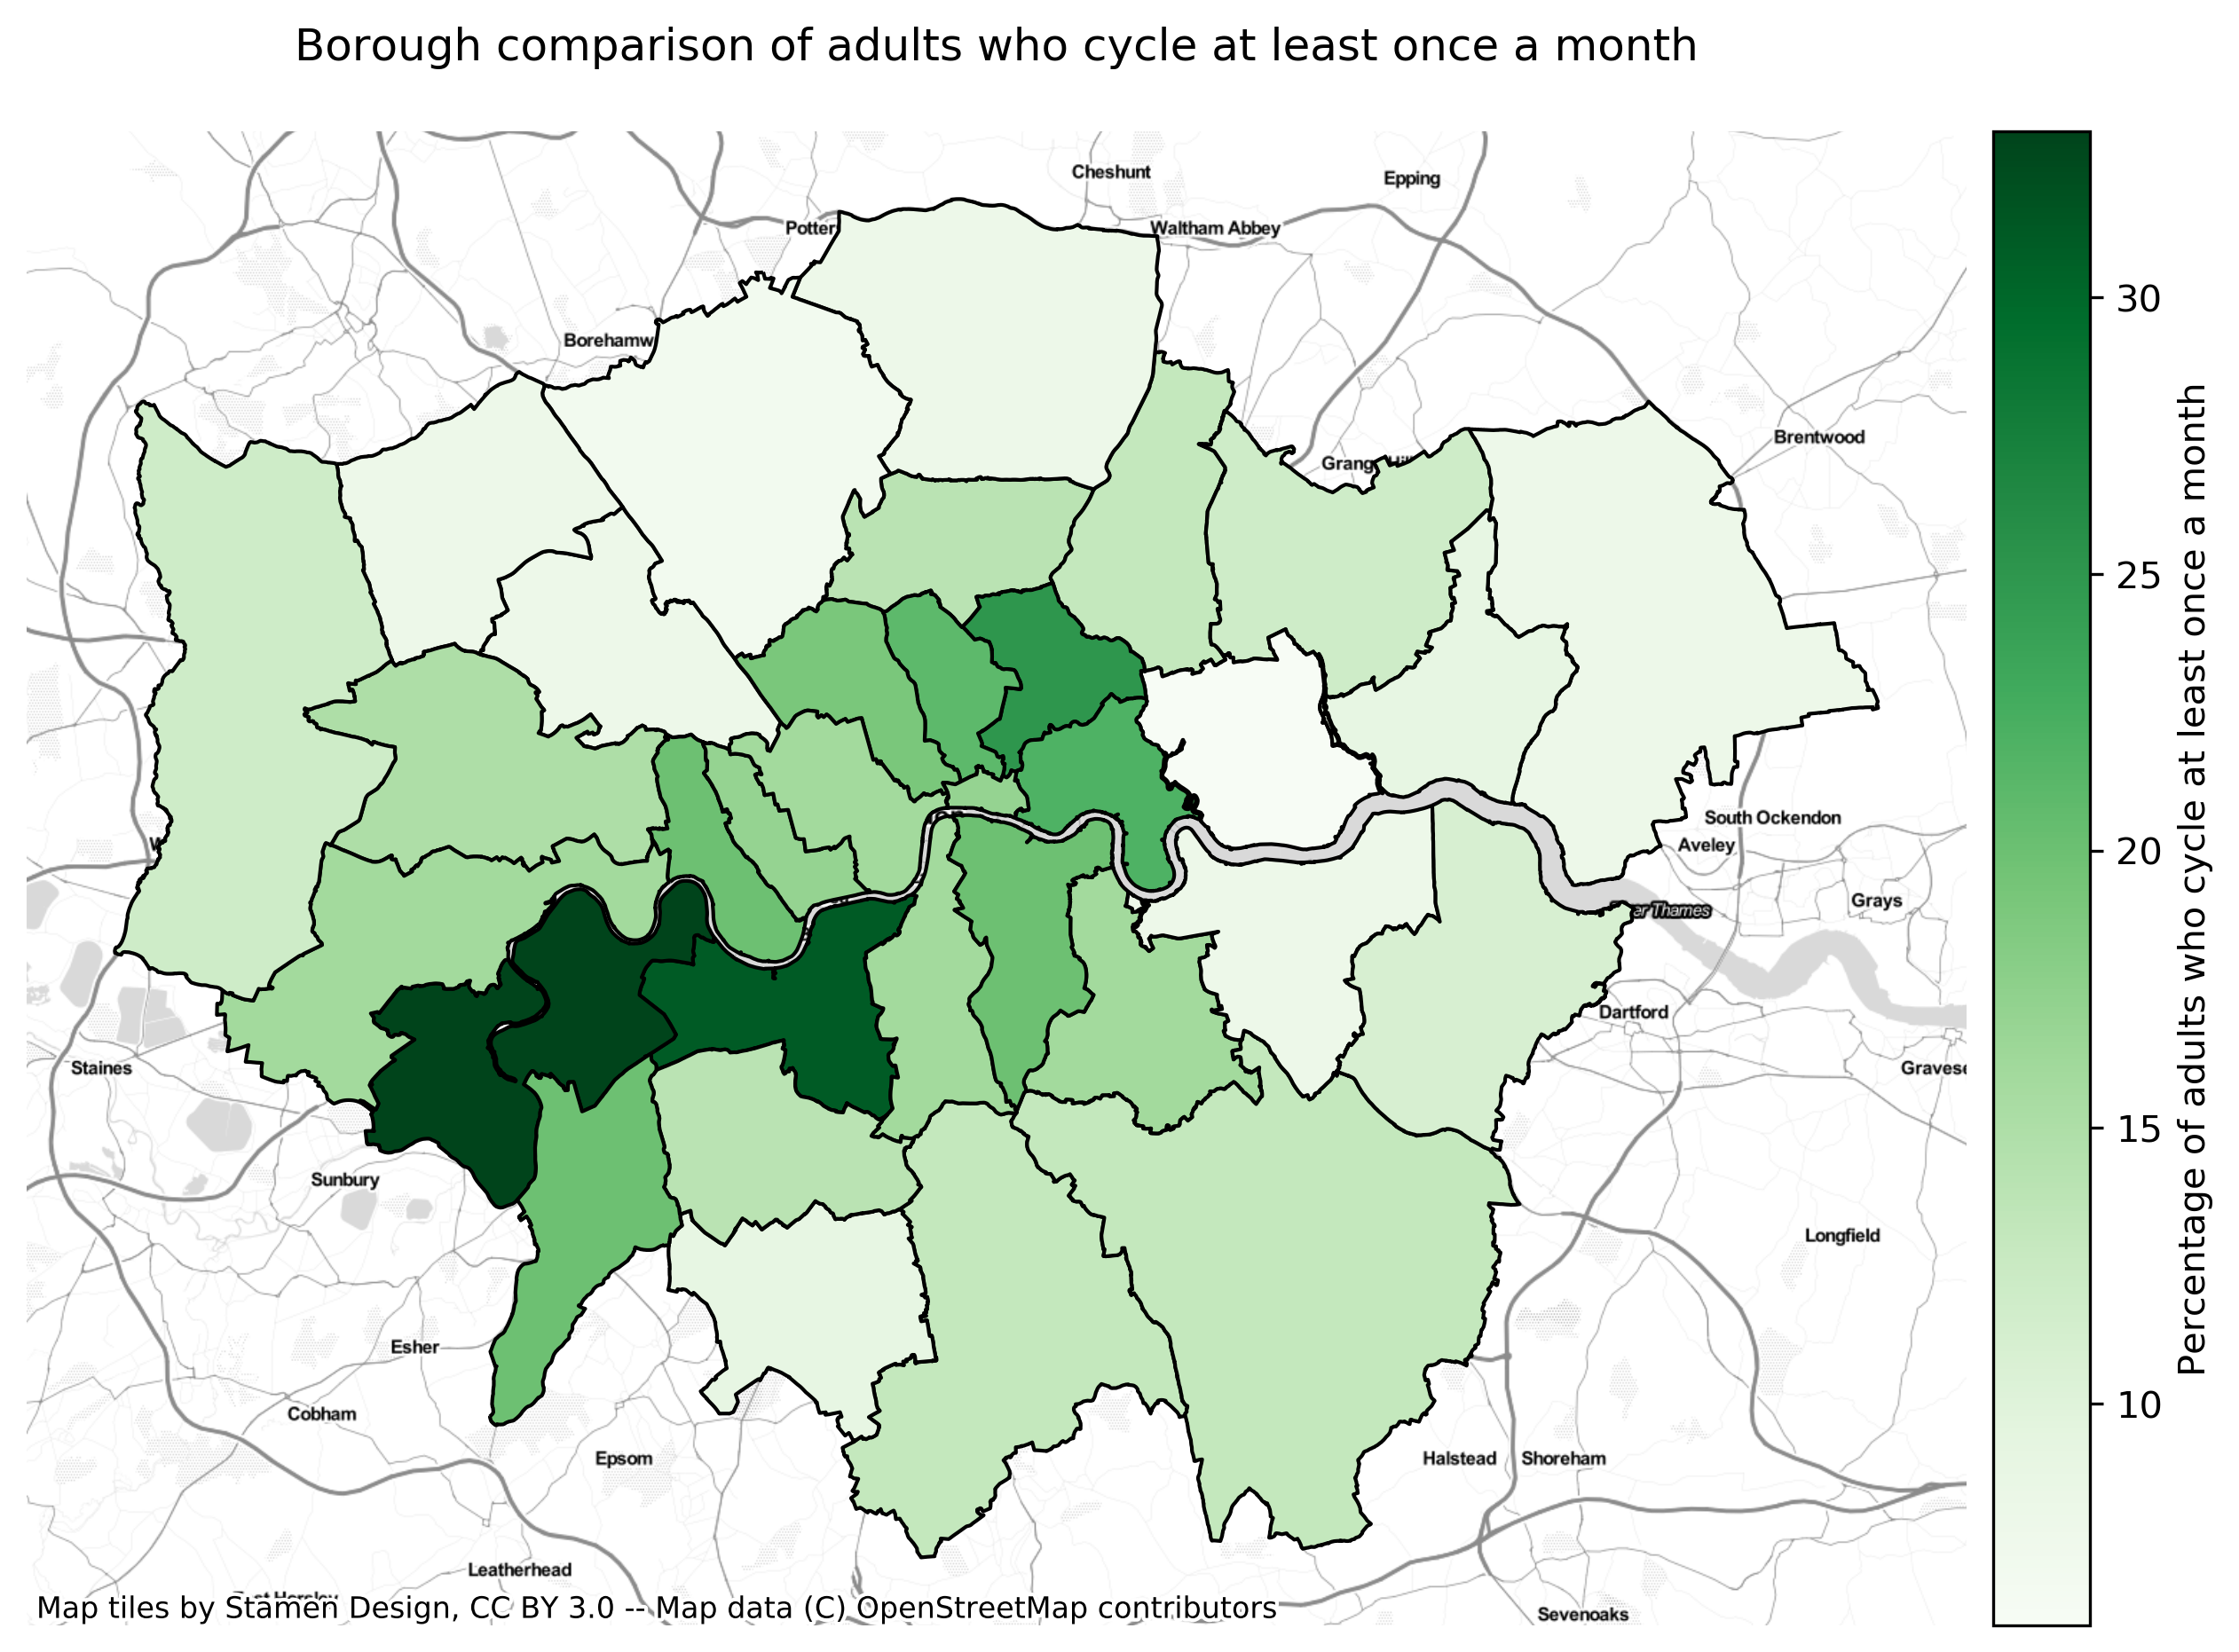

In [17]:
plt.rcParams['figure.dpi'] = 300

fig, ax = plt.subplots(1, 1, figsize=(10, 8))

vmax, vmin = 33, 6

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)

ax = borough_map.plot(figsize=(10, 8), 
                      column='b_percentage adults cycle once a month 2014/15', 
                      cmap = 'Greens', 
                      edgecolor='k',
                      legend = False,
                      linewidth=1,
                      alpha=1,
                      cax=cax,
                      ax=ax) 


norm = colors.Normalize(vmin=vmin, vmax=vmax)
cbar = plt.cm.ScalarMappable(norm=norm, cmap='Greens')
ax_cbar = fig.colorbar(cbar, ax=ax, cax=cax)
ax_cbar.set_label('Percentage of adults who cycle at least once a month')

ax.set_title('Borough comparison of adults who cycle at least once a month\n', 
                 fontdict={'fontsize': '12', 'fontweight' : '2'})

ctx.add_basemap(ax=ax, url=ctx.providers.Stamen.TonerLite)

ax.axis('off')
plt.show()

### To understand how travel modes and travel times have changed over a 10 year period, looking at the London Travel Demand survey (https://tfl.gov.uk/corporate/about-tfl/how-we-work/planning-for-the-future/consultations-and-surveys). Latest survey results are years 2017/2018, so comparing these results with year 2007/2008.

In [18]:
df_2 = pd.read_csv('/Users/oliverpaul/Data_Science/EDF/LTDS- survey/total_trips_by_start_time.csv')

In [19]:
df_2 = df_2[['start_time', '2007/08', '2017/18']].melt(id_vars=['start_time'])

In [20]:
df_2['value'] = df_2['value'].str.replace("'", '').astype(int)

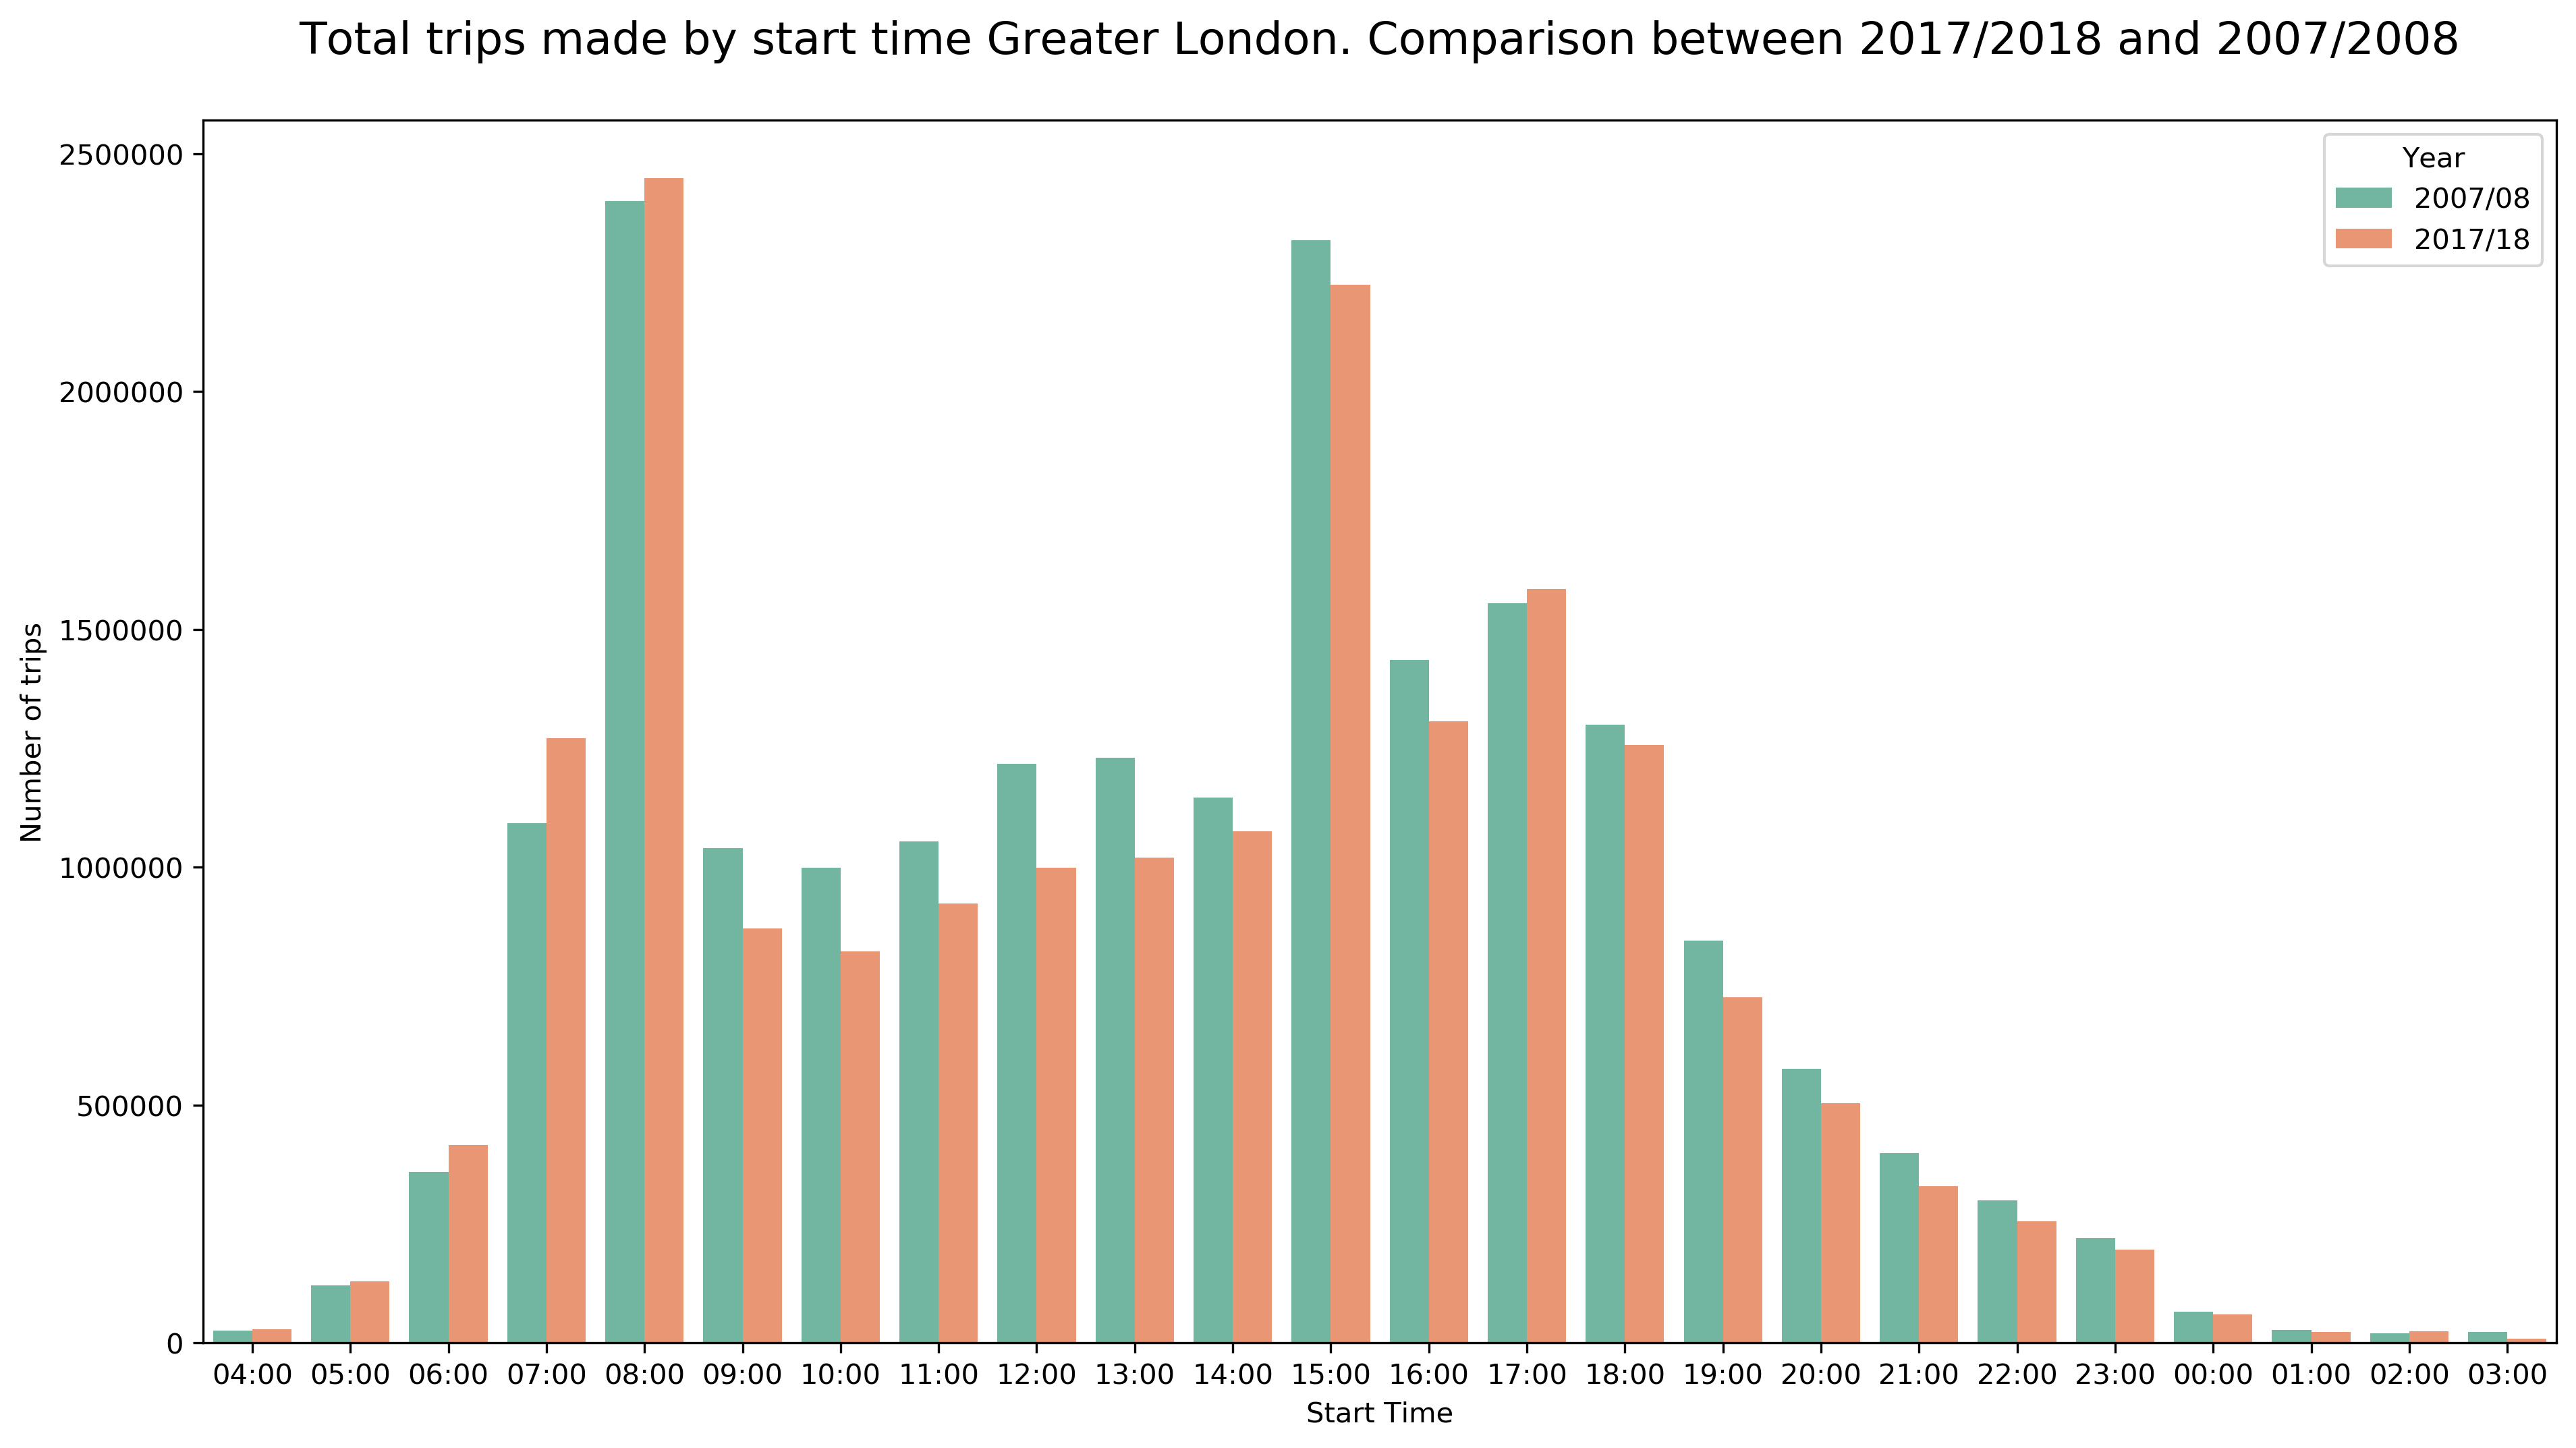

In [21]:
plt.rcParams['figure.figsize'] = (15,8)
plt.rcParams['figure.dpi'] = 300

ax = sns.barplot(y='value', x= 'start_time', hue = 'variable' , data= df_2, palette = 'Set2')

legend = ax.legend(loc ='upper right', title = 'Year')

ax.set(xlabel='Start Time', ylabel='Number of trips')
ax.set_title("Total trips made by start time Greater London. Comparison between 2017/2018 and 2007/2008\n",
             fontdict={'fontsize': '16', 'fontweight' : '5'})

plt.show()

### In 2017/18 more trips are made in the early morning, with less trips being made during the day. This may be a result of people commuting from greater distances, and hence staying at the place of work during the day 

### Looking at average trip times per person per day across various transport modes for the two time periods 

In [22]:
df_3 = pd.read_csv('/Users/oliverpaul/Data_Science/EDF/LTDS- survey/time_minutes_per_person_per_day_outer_london.csv')

In [23]:
df_3 = df_3[['mode', '2007/08', '2017/18']]
df_3 = df_3.melt(id_vars=['mode']).sort_values('value')

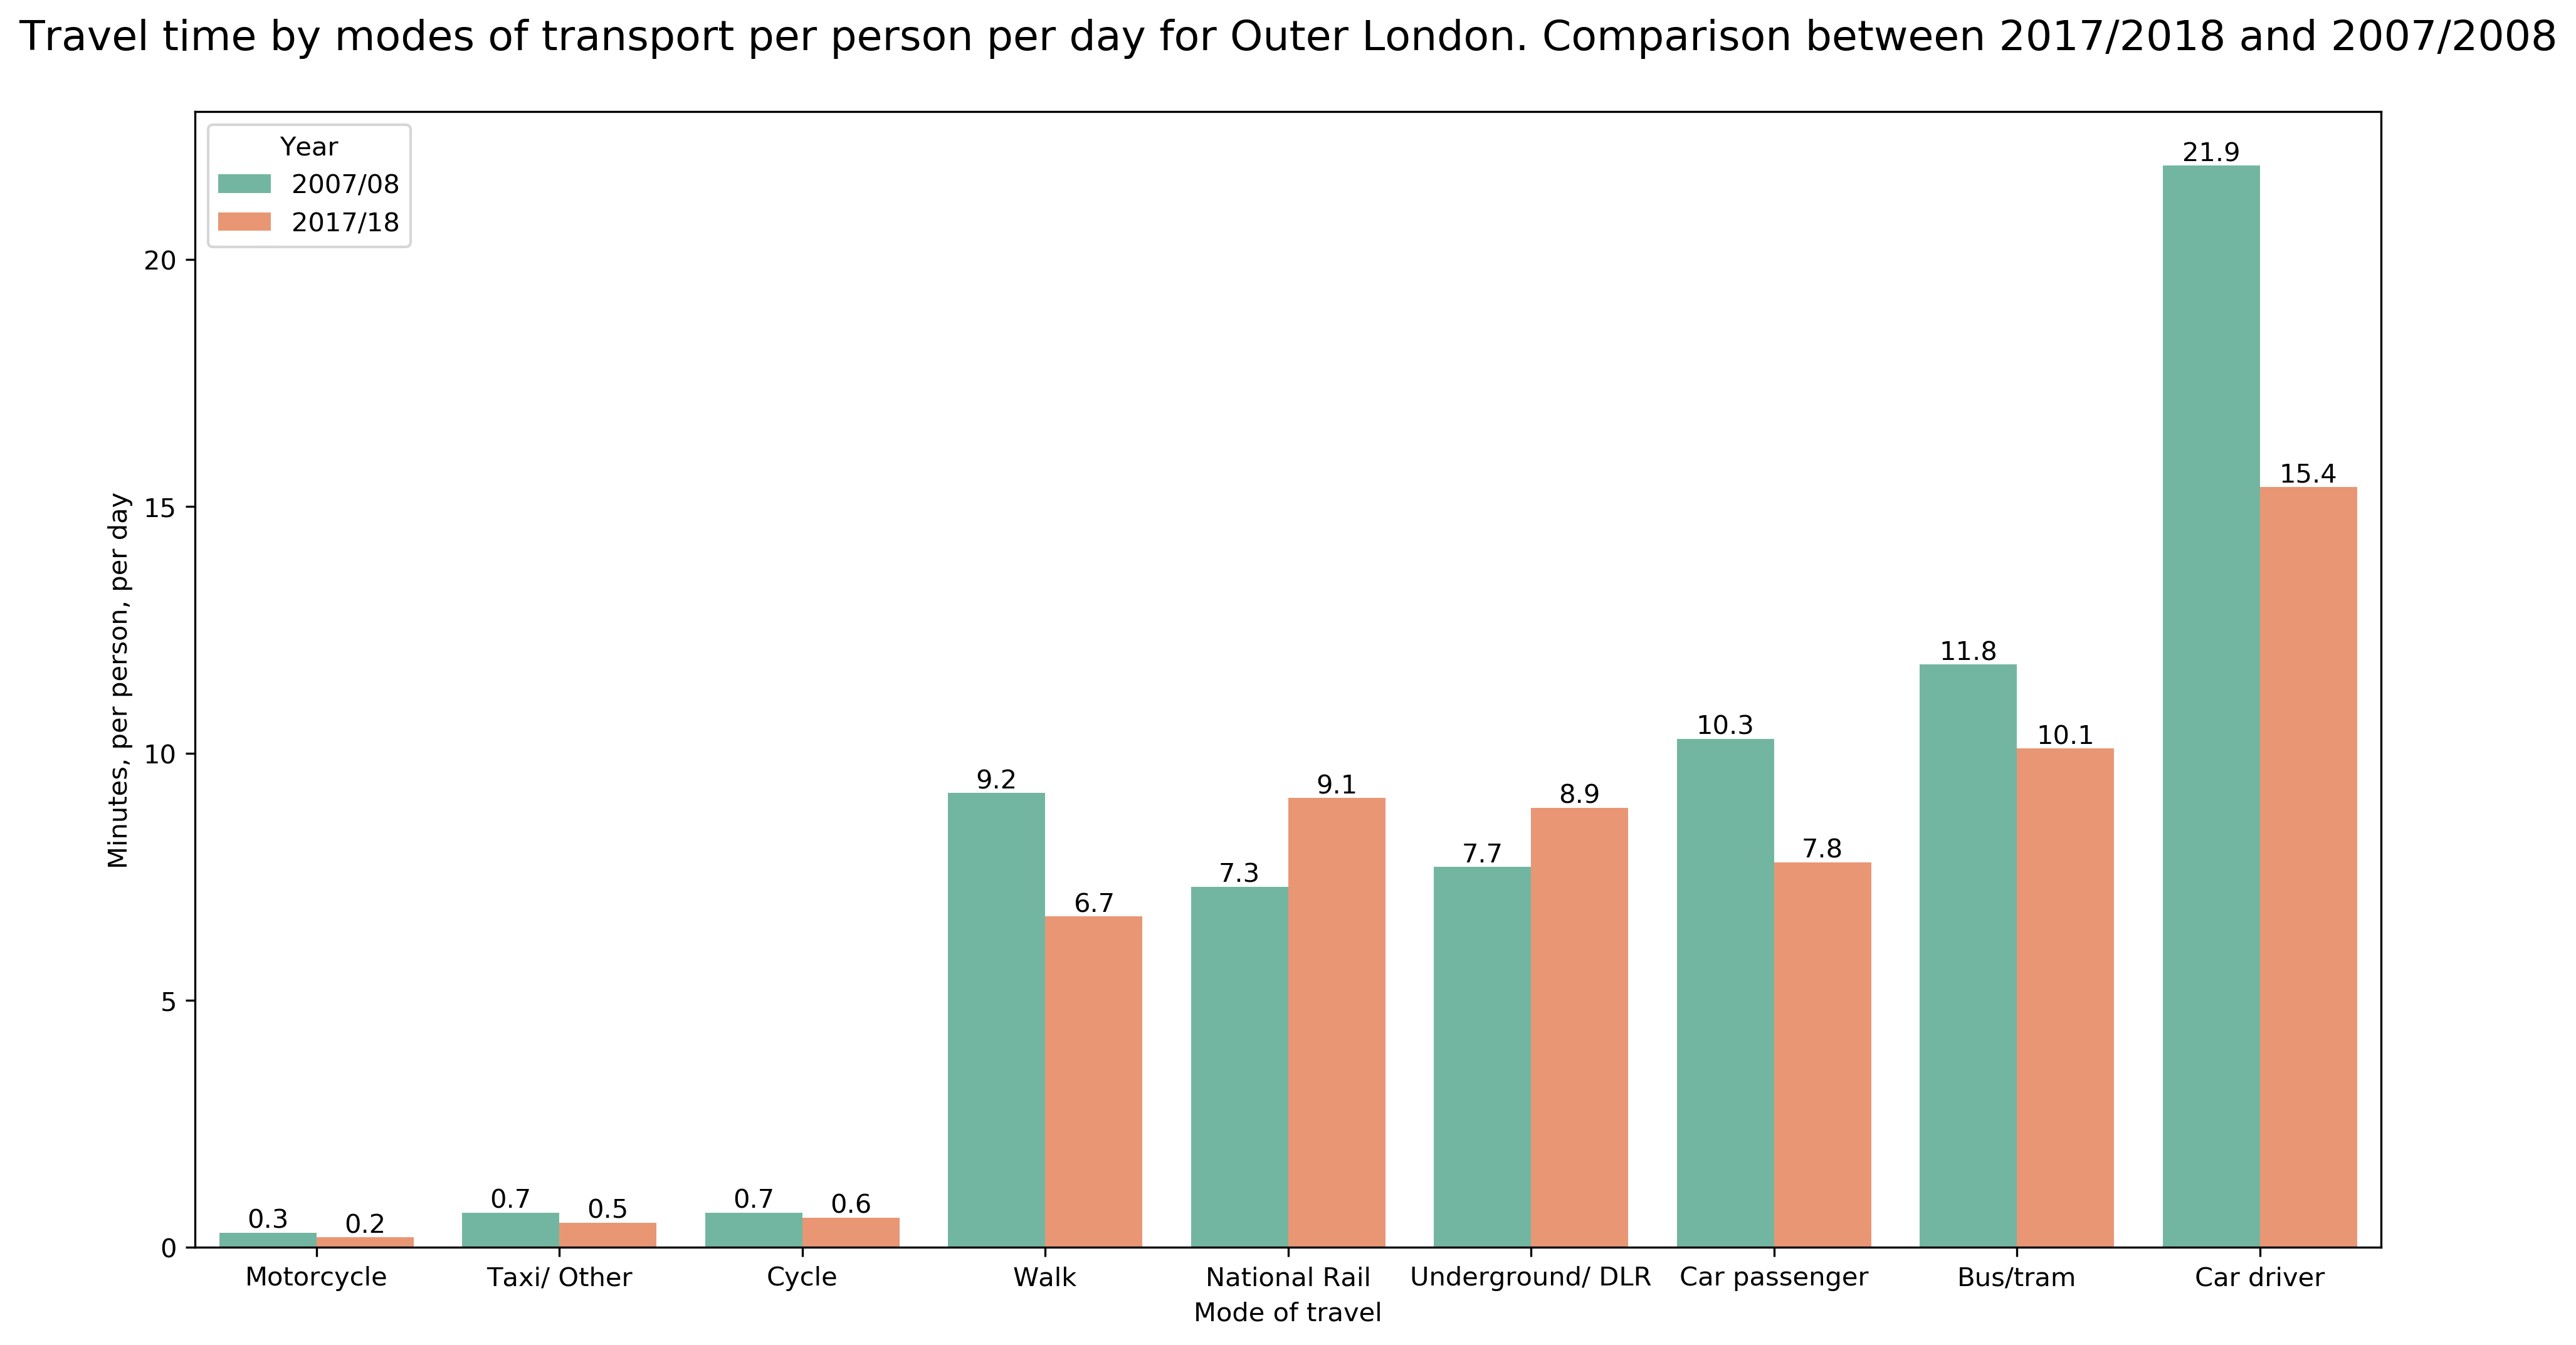

In [24]:
plt.rcParams['figure.figsize'] = (15,8)
plt.rcParams['figure.dpi'] = 300

fig, ax = plt.subplots()

ax = sns.barplot(ax=ax,y='value', x= 'mode', hue = 'variable' , data= df_3, palette = 'Set2', hue_order = ['2007/08', '2017/18'])

for i in ax.patches:
    height = i.get_height()
    ax.text(i.get_x()+i.get_width()/2., height + 0.1,height ,ha="center")

legend = ax.legend(loc =[0][0], title = 'Year')

ax.set(xlabel='Mode of travel', ylabel='Minutes, per person, per day')
ax.set_title("Travel time by modes of transport per person per day for Outer London. Comparison between 2017/2018 and 2007/2008\n",
             fontdict={'fontsize': '16', 'fontweight' : '5'})

plt.show()

### Same for Inner London

In [25]:
df_4 = pd.read_csv('/Users/oliverpaul/Data_Science/EDF/LTDS- survey/time_minutes_per_person_per_day_inner_london.csv')
df_4 = df_4[['mode', '2007/08', '2017/18']]
df_4 = df_4.melt(id_vars=['mode']).sort_values('value')

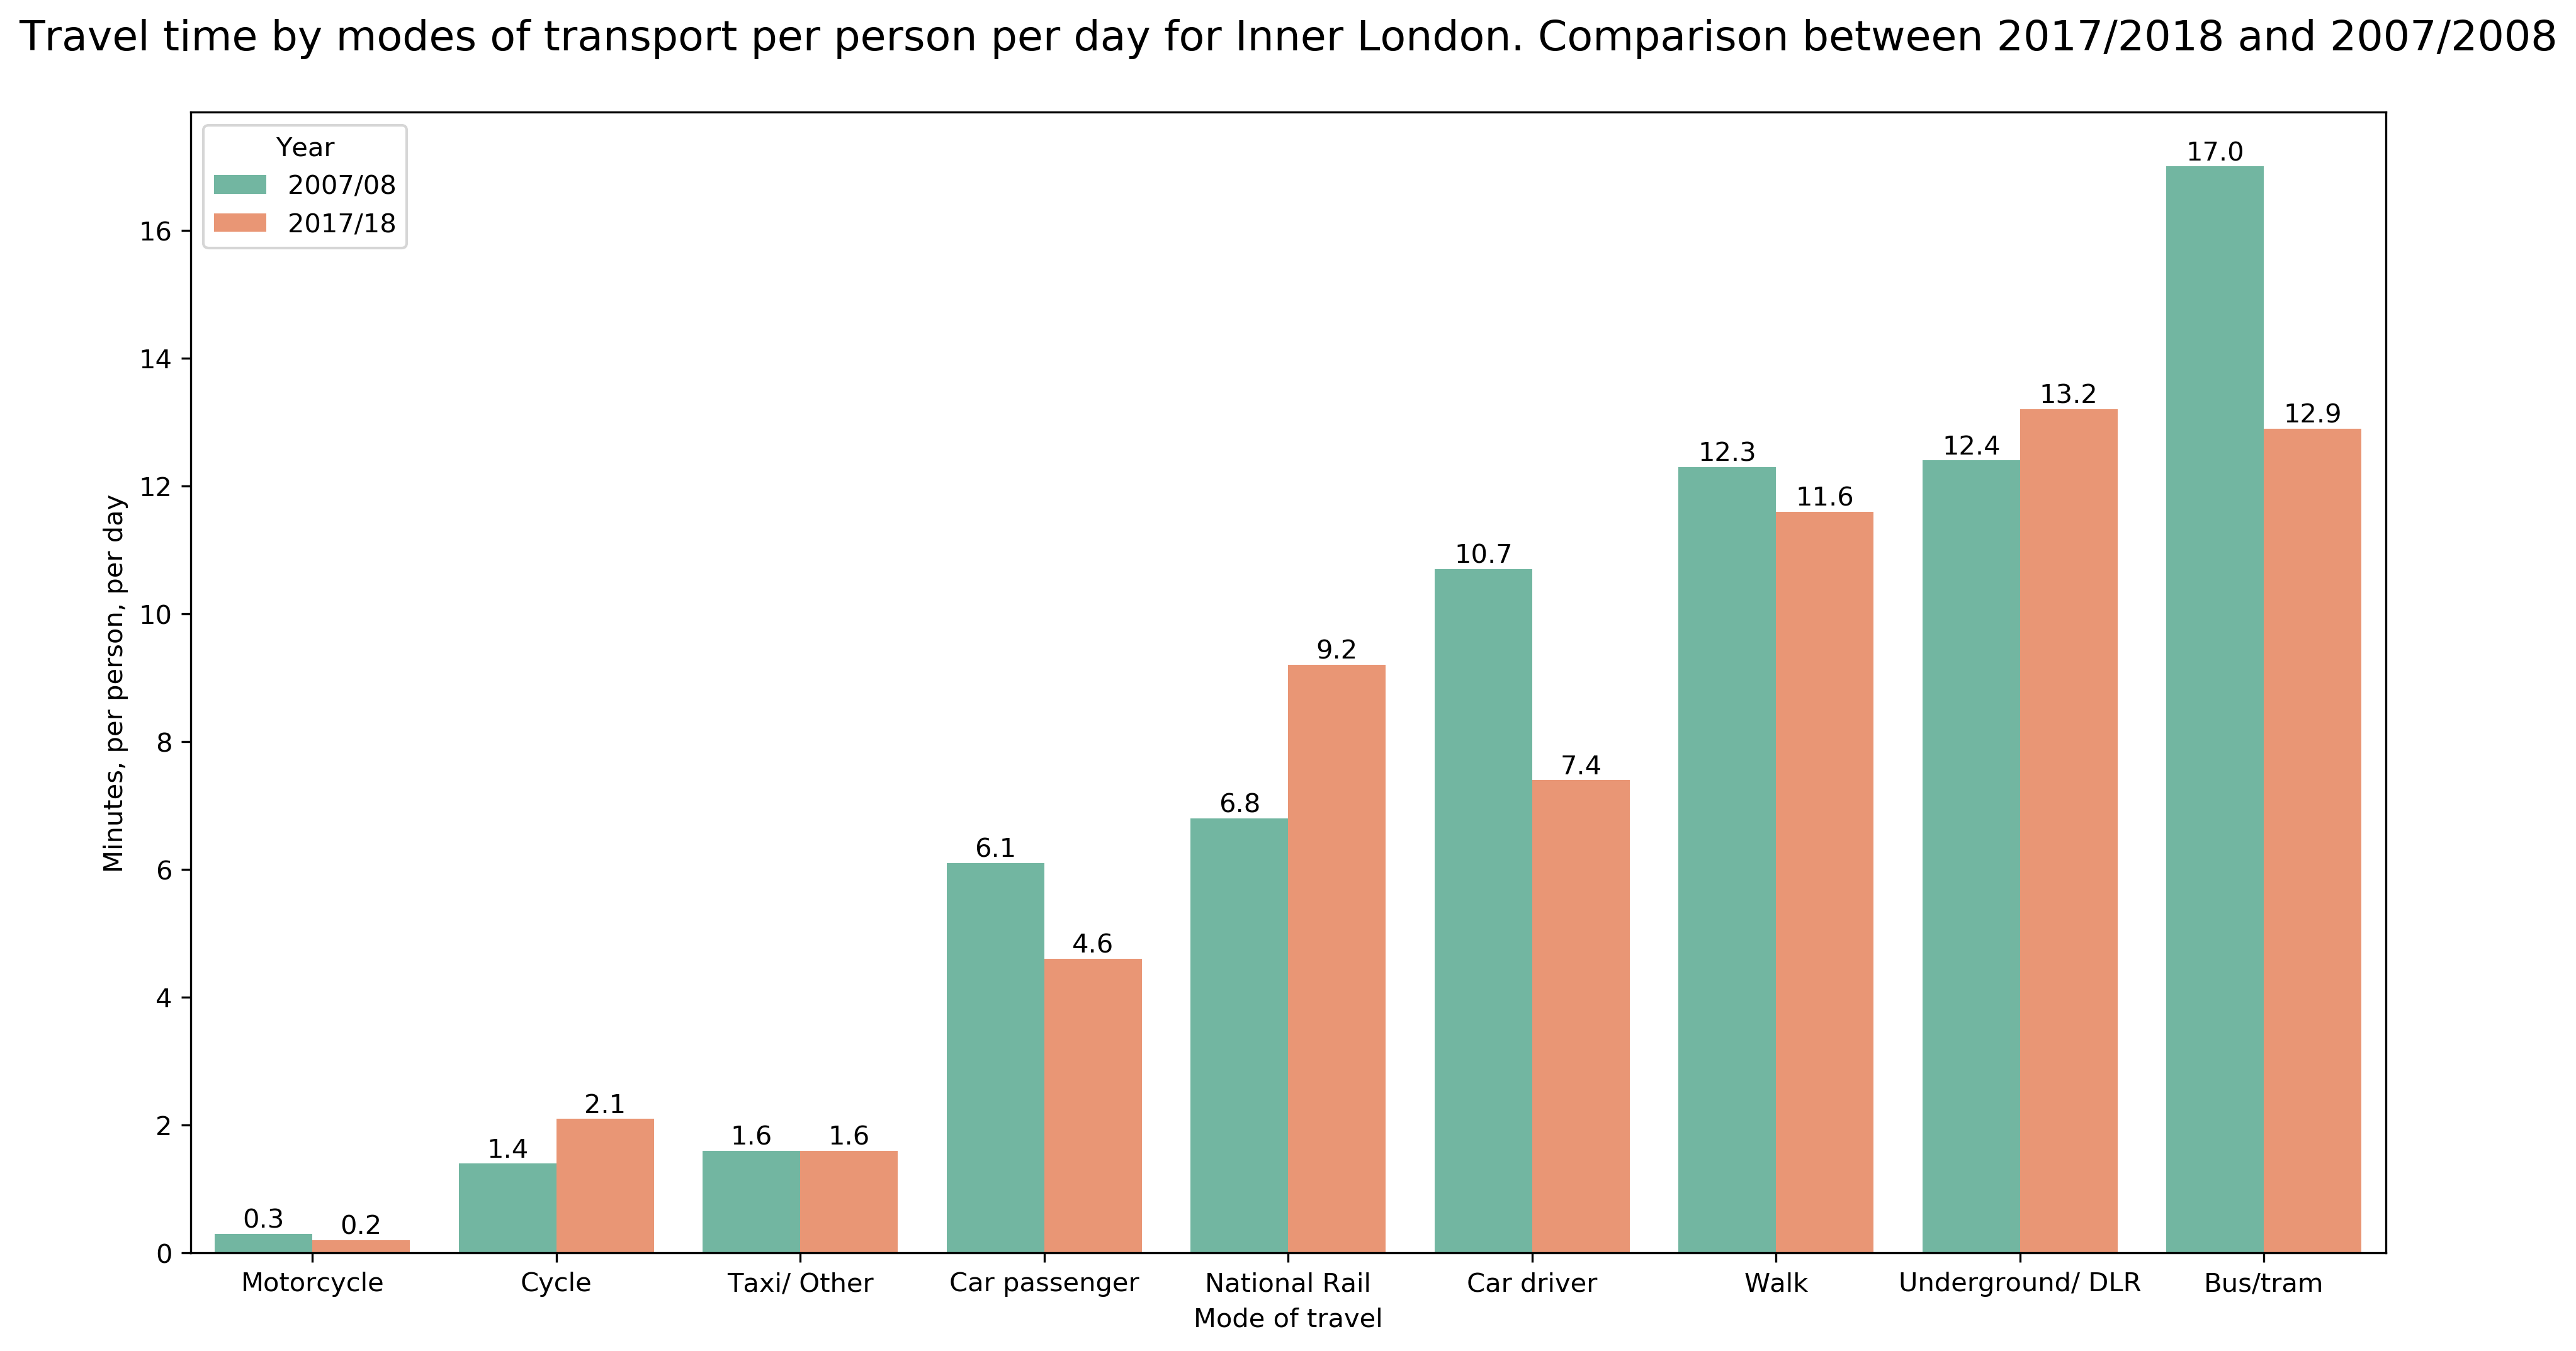

In [26]:
plt.rcParams['figure.figsize'] = (15,8)
plt.rcParams['figure.dpi'] = 300

fig, ax = plt.subplots()

ax = sns.barplot(ax=ax, y='value', x= 'mode', hue = 'variable' , data= df_4, palette = 'Set2', hue_order = ['2007/08', '2017/18'])

for i in ax.patches:
    height = i.get_height()
    ax.text(i.get_x()+i.get_width()/2., height + 0.1,height ,ha="center")

legend = ax.legend(loc =[0][0], title = 'Year')

ax.set(xlabel='Mode of travel', ylabel='Minutes, per person, per day')
ax.set_title("Travel time by modes of transport per person per day for Inner London. Comparison between 2017/2018 and 2007/2008\n",
             fontdict={'fontsize': '16', 'fontweight' : '5'})

plt.show()

### We see clear differences in transport mode choices between outer and inner London. Also of note, in inner London the time spent cycling has increased by 50% between 2007/08 and 2017/18